<a href="https://colab.research.google.com/github/Michelle-Lohwt/fetal-cardiotocography-analysis/blob/main/neural_network_and_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group Cardio_4

Group Members
1. Pan Kwong Sing (152687)
2. Lim Phei San (152726)
3. Lim Zi Qiang (153116)
4. Loh Wan Teng (149104)

The team decided to use 'NSP' class as the output, so the 'CLASS' column (FHR pattern class code (1 to 10)) is dropped.

## Import Libraries and Dataset

In [ ]:
pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.9 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import scale, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

In [ ]:
cardio_df = pd.read_csv('ctg.csv',sep=';')

## Exploratory Data Analysis, Data Preprocessing and Data Cleaning

### Understanding Dataset

In [ ]:
cardio_df.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2.0
1,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1.0
2,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6.0,1.0
3,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6.0,1.0
4,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0,1.0


In [ ]:
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   float64
 1   AC        2126 non-null   float64
 2   FM        2127 non-null   float64
 3   UC        2127 non-null   float64
 4   ASTV      2127 non-null   float64
 5   MSTV      2127 non-null   float64
 6   ALTV      2127 non-null   float64
 7   MLTV      2127 non-null   float64
 8   DL        2128 non-null   float64
 9   DS        2128 non-null   float64
 10  DP        2128 non-null   float64
 11  Width     2126 non-null   float64
 12  Min       2126 non-null   float64
 13  Max       2126 non-null   float64
 14  Nmax      2126 non-null   float64
 15  Nzeros    2126 non-null   float64
 16  Mode      2126 non-null   float64
 17  Mean      2126 non-null   float64
 18  Median    2126 non-null   float64
 19  Variance  2126 non-null   float64
 20  Tendency  2126 non-null   floa

### Drop 'CLASS' column

In [ ]:
cardio_df = cardio_df.drop(columns = ['CLASS'])

In [ ]:
cardio_df.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'NSP'],
      dtype='object')

### Drop Null or NA Rows

If you observe the "Non-Null Count", there is null values exists.

In [ ]:
cardio_df.isna().sum()

LB          3
AC          3
FM          2
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DL          1
DS          1
DP          1
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
NSP         3
dtype: int64

In [ ]:
# Check null rows in dataset
null_rows = cardio_df[cardio_df.isna().any(axis=1)]
null_rows

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,564.0,23.0,87.0,7.0,91.0,50.7,16.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since there is only 3 rows that consists of "NA", the team decided to remove them as it does not has high proportion of the overall rows of values.

In [ ]:
# Remove null rows
cardio_df = cardio_df.dropna()

In [ ]:
# Check dataframe info again
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   float64
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   ASTV      2126 non-null   float64
 5   MSTV      2126 non-null   float64
 6   ALTV      2126 non-null   float64
 7   MLTV      2126 non-null   float64
 8   DL        2126 non-null   float64
 9   DS        2126 non-null   float64
 10  DP        2126 non-null   float64
 11  Width     2126 non-null   float64
 12  Min       2126 non-null   float64
 13  Max       2126 non-null   float64
 14  Nmax      2126 non-null   float64
 15  Nzeros    2126 non-null   float64
 16  Mode      2126 non-null   float64
 17  Mean      2126 non-null   float64
 18  Median    2126 non-null   float64
 19  Variance  2126 non-null   float64
 20  Tendency  2126 non-null   floa

In [ ]:
# Check null values again
cardio_df.isna().sum()

LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
NSP         0
dtype: int64

### Drop Duplicated Rows

In [ ]:
cardio_df.shape

(2126, 22)

In [ ]:
cardio_df = cardio_df.drop_duplicates()

In [ ]:
cardio_df.shape

(2112, 22)

### Outliers Treament

In [ ]:
cardio_df.describe(include = 'all')

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,...,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000
mean,133.296875,2.733902,7.267992,3.678504,46.978693,1.335559,9.759943,8.169176,1.580492,0.003314,...,93.539299,164.105587,4.078598,0.325758,137.448390,134.592803,138.083333,18.916193,0.318655,1.303030
std,9.833066,3.567741,37.244378,2.844685,17.167716,0.884232,18.270136,5.633034,2.504219,0.057489,...,29.546379,17.947492,2.951603,0.707903,16.403636,15.610971,14.479658,29.042726,0.611180,0.613314
min,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.000000,4.600000,0.000000,0.000000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.000000,7.400000,0.000000,0.000000,...,93.000000,162.000000,4.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.000000,10.800000,3.000000,0.000000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.000000,50.700000,16.000000,1.000000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [ ]:
cardio_df.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'NSP'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


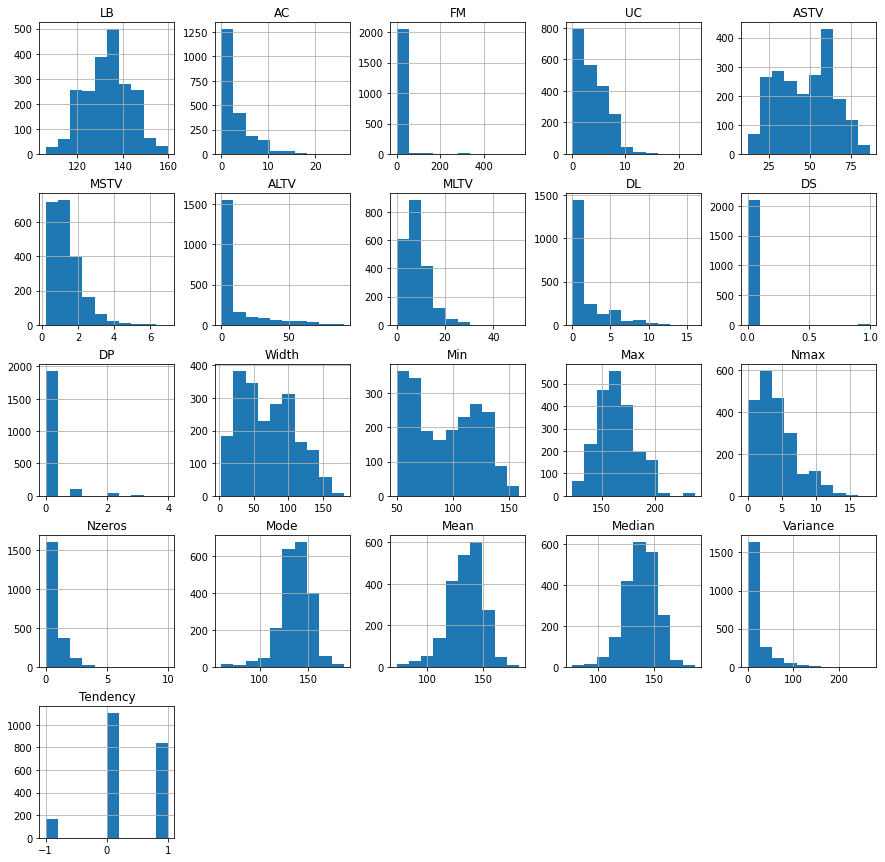

In [ ]:
# Histogram for all features
features = cardio_df.drop(columns=['NSP'])
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
features.hist(ax=ax)
plt.show()

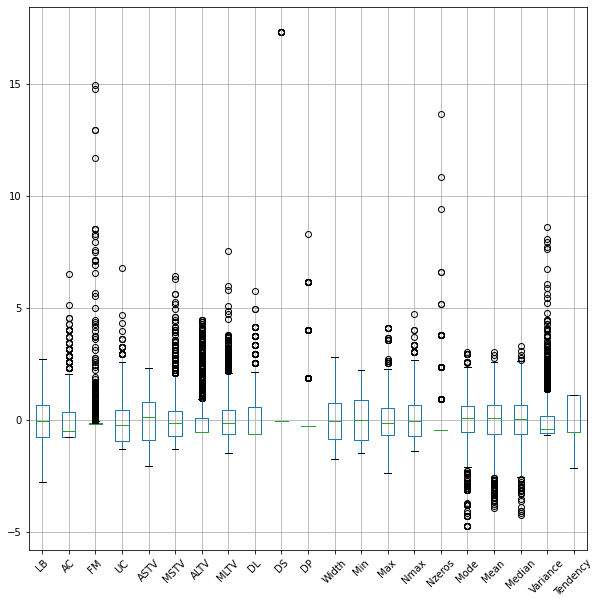

In [ ]:
# Boxplots for feature distributions
fig, ax = plt.subplots(figsize=(10, 10))
outliers_plot = pd.DataFrame(scale(features), columns = features.columns)
outliers_plot.boxplot(ax=ax, rot=45)
plt.show()

There are a few features that are more than 5 times deviated from the normal distribution, which the reasons are but not limited to:
1. Measurement Error
2. Sampling problems
3. Instrument Error

. If the outliers are errors, this can negatively impact the performance of our classifiers.

Since the team has no sufficient information whether the outliers are due to errors, outliers treatment is not performed.

### Correlation of Features

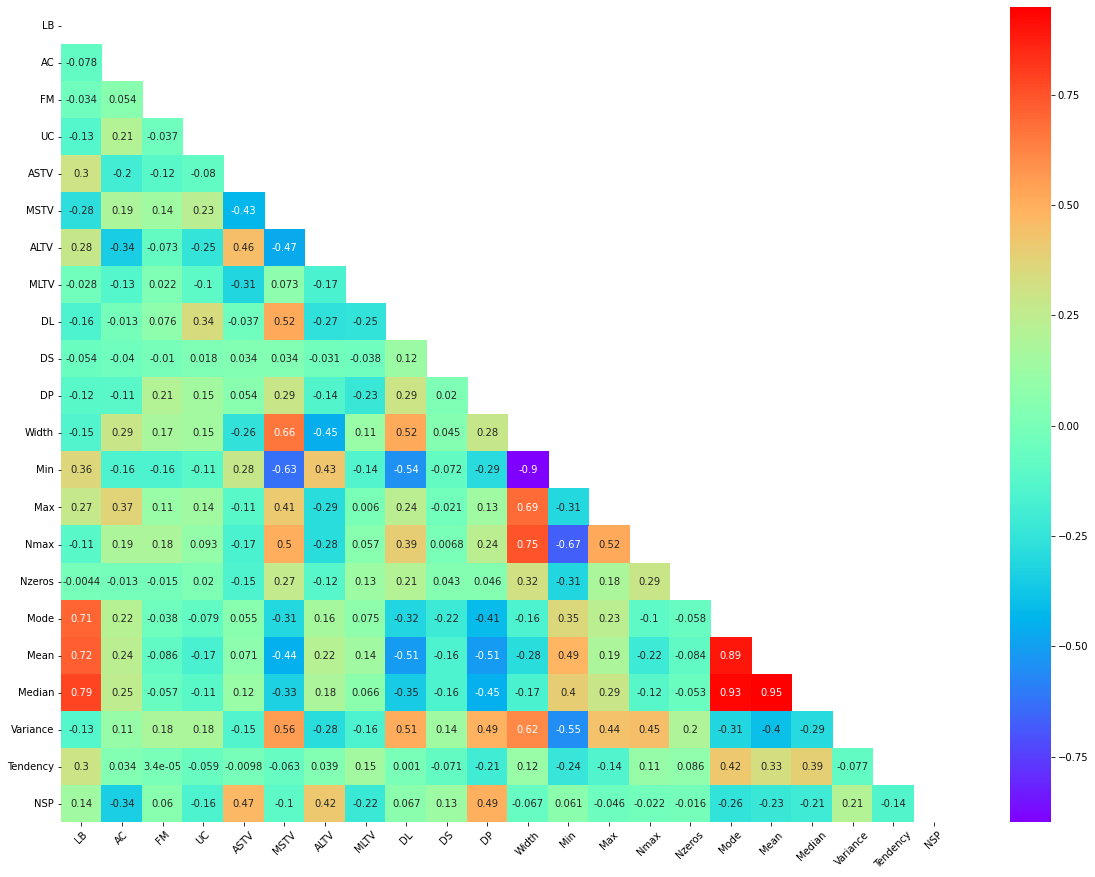

In [ ]:
# Feature correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
corr = cardio_df.corr()
sns.heatmap(corr, mask = np.triu(corr), cmap = 'rainbow', annot=True, ax=ax)
plt.xticks(rotation=45)
plt.show()

The map does not show any strong positive correlation between the features describing the NSP class. The significant positive correlation describing the NSP class on the map are:
1. DP (# of prolongued decelerations per second)
2. ASTV (percentage of time with abnormal short term variability)
3. ALTV value (percentage of time with abnormal long term variability).

These 3 columns should be paid attention during feature selection.

## Feature Selection

#### Splitting training and testing set

In [ ]:
X = cardio_df.drop(columns = ['NSP'])
y = cardio_df['NSP']

In [ ]:
# Get feature names
features = X.columns
features

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

print('X train size : ', X_train.shape)
print('y train size : ', y_train.shape)
print('X test size : ', X_test.shape)
print('y test size : ', y_test.shape)

X train size :  (1900, 21)
y train size :  (1900,)
X test size :  (212, 21)
y test size :  (212,)


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [ ]:
# Put back columns name
X_train.columns = X.columns
X_test.columns = X.columns

#### Feature Selection with Wrapper Method using Random Forest

In [ ]:
seed = 42

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2,
                                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                                      bootstrap=True, oob_score=False, n_jobs=-1, random_state=seed, class_weight='balanced')

In [ ]:
rf_sbs = SFS(random_forest, 
            k_features='best', forward=False, 
            floating=False, verbose=2, scoring='accuracy', cv = 5)

In [ ]:
rf_sbs.fit(X_train, y_train, custom_feature_names = features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   41.2s finished

[2022-07-17 03:17:28] Features: 20/1 -- score: 0.8521052631578947[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   40.6s finished

[2022-07-17 03:18:09] Features: 19/1 -- score: 0.8542105263157895[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   38.2s finished

[2022-07-17 03:18:47] Features: 18/1 -- score: 0.8642105263157894[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=RandomForestClassifier(class_weight='balanced',
                                                           max_depth=2,
                                                           n_jobs=-1,
                                                           random_state=42),
                          forward=False, k_features='best', scoring='accuracy',
                          verbose=2)

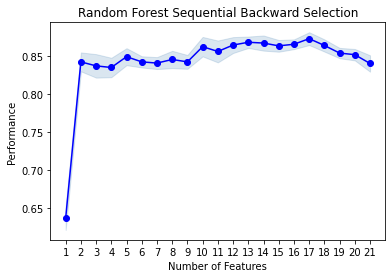

In [ ]:
figl = plot_sfs(rf_sbs.get_metric_dict(confidence_interval=0.95), kind='std_err')

plt.title('Random Forest Sequential Backward Selection')
plt.show()

In [ ]:
sbs_summary = pd.DataFrame.from_dict(rf_sbs.get_metric_dict()).T
print(sbs_summary[["feature_idx", "avg_score"]].sort_values(by='avg_score', ascending=False))

                                          feature_idx avg_score
17  (0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 1...  0.873158
13    (0, 4, 5, 6, 8, 10, 11, 12, 14, 16, 17, 19, 20)  0.868421
14  (0, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19...  0.867368
16  (0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, ...  0.865789
12        (0, 4, 5, 6, 8, 10, 11, 12, 14, 16, 17, 19)  0.864737
18  (0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...  0.864211
15  (0, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17,...  0.863684
10               (0, 4, 5, 8, 10, 11, 12, 14, 17, 19)  0.862632
11           (0, 4, 5, 8, 10, 11, 12, 14, 16, 17, 19)  0.856316
19  (0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...  0.854211
20  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.852105
5                                  (4, 5, 14, 17, 19)  0.849474
8                      (4, 5, 10, 11, 12, 14, 17, 19)  0.845789
6                              (4, 5, 11, 14, 17, 19)  0.842632
2                                       

In [ ]:
# Indices of the best features
rf_sbs.k_feature_names_, rf_sbs.k_feature_idx_

(('LB',
  'FM',
  'UC',
  'ASTV',
  'MSTV',
  'ALTV',
  'DL',
  'DS',
  'DP',
  'Width',
  'Min',
  'Nmax',
  'Nzeros',
  'Mode',
  'Mean',
  'Variance',
  'Tendency'),
 (0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20))

#### Training and Testing set after feature selection

In [ ]:
X_train_featured = X_train.iloc[:,np.array(rf_sbs.k_feature_idx_)]
X_test_featured = X_test.iloc[:,np.array(rf_sbs.k_feature_idx_)]

## Model Training and Confusion Matrix Report

In [ ]:
print('X train size : ', X_train_featured.shape)
print('y train size : ', y_train.shape)
print('X test size : ', X_test_featured.shape)
print('y test size : ', y_test.shape)

X train size :  (1900, 17)
y train size :  (1900,)
X test size :  (212, 17)
y test size :  (212,)


### Confusion Matrix Report Function

In [ ]:
def cof_mat(cf_matrix, model):
  group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
            zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(3,3)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title(model + ' Model Confusion Matrix\n\n');
  ax.set_xlabel('\nPredicted Category')
  ax.set_ylabel('Actual Category');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Normal','Suspect', 'Pathologic'])
  ax.yaxis.set_ticklabels(['Normal','Suspect', 'Pathologic'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

### Artificial Neural Network (ANN)

#### Model Training

A simple Artificial Neural Network of 4 layers (1 input, 1 output, and 2 hidden layers) is built. 

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
ohe = OneHotEncoder()
y_train_ann = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()

Number of hidden neurons in the hidden layer: `2/3 the size of the input layer + size of the output layer`.

1. Size of input layer: number of columns of `X_train_featured`.
2. Size of output layer: 3.

Reference: [StackExchange](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

In [ ]:
output_size = 3

In [ ]:
# Output dimension of each layer
output_dim = int(np.ceil(X_train_featured.shape[1] * 2/3) + output_size)

In [ ]:
output_dim

15

In [ ]:
# ANN model

# Initializing the ANN
ann_model = Sequential()

# Adding the input layer and the first hidden layer
ann_model.add(Dense(output_dim, activation = 'relu', input_dim = X_train_featured.shape[1]))

# Adding the second hidden layer
ann_model.add(Dense(output_dim, activation = 'relu'))

# Adding the output layer
ann_model.add(Dense(output_size, activation = 'softmax'))

# Compiling the ANN
ann_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                270       
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 558
Trainable params: 558
Non-trainable params: 0
_________________________________________________________________


In general: 

- Larger batch sizes result in faster progress in training, but don't always converge fast. Smaller batch sizes train slower, but can converge faster, so one can choose any batch_size depends on training time and RAM usage.

- Models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge.

Note: We will test 
- `batch_size` with power of 2 from 32 to 64 and
- `epochs` with 128 and 256,

to maximise the usage of GPU processing and to find out the model with highest accuracy with differenct batch size and number of epoch.

Reference: [Stackoverflow](https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model)

We will only test 2 values for both `batch_size` and `epochs` as recommended in the reference mentioned above because of time constrains.

In [ ]:
batches = [32, 64]
epochs = [128, 256]

In [ ]:
max_accuracy = float('-inf')

for epoch in epochs:
  for batch in batches:
    ann_model.fit(X_train_featured, y_train_ann, batch_size = batch, epochs = epoch, validation_split = 0.1)  # Fitting the ANN to the Training set and Validation Set
    y_pred = ann_model.predict(X_test_featured) # Predict output
    y_pred_labels = [(np.argmax(label) + 1) for label in y_pred]  # Convert output to an array with correct input (1: Normal, 2: Suspect, 3: Pathologic) with y_test
    accuracy = accuracy_score(y_test, y_pred_labels)  # Calculate accuracy score

    # Find maximum accuracy 
    if accuracy > max_accuracy:
      max_accuracy = accuracy
      cf_matrix = confusion_matrix(y_test, y_pred_labels) # Generate confusion matrix
      clf_report = classification_report(y_test, y_pred_labels) # Generate classification report
      batch_size = batch
      epoch_size = epoch

Epoch 1/128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


54/54 [==============================] - 2s 20ms/step - loss: 1.1413 - accuracy: 0.3257 - val_loss: 0.9526 - val_accuracy: 0.6526
Epoch 2/128
 4/54 [=>............................] - ETA: 0s - loss: 0.9841 - accuracy: 0.6953

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


54/54 [==============================] - 1s 19ms/step - loss: 0.8417 - accuracy: 0.7760 - val_loss: 0.7411 - val_accuracy: 0.8263
Epoch 3/128
54/54 [==============================] - 1s 19ms/step - loss: 0.6332 - accuracy: 0.8257 - val_loss: 0.5702 - val_accuracy: 0.8053
Epoch 4/128
54/54 [==============================] - 1s 24ms/step - loss: 0.4752 - accuracy: 0.8404 - val_loss: 0.4562 - val_accuracy: 0.8316
Epoch 5/128
54/54 [==============================] - 1s 26ms/step - loss: 0.3798 - accuracy: 0.8813 - val_loss: 0.3938 - val_accuracy: 0.8526
Epoch 6/128
54/54 [==============================] - 1s 19ms/step - loss: 0.3317 - accuracy: 0.8889 - val_loss: 0.3600 - val_accuracy: 0.8632
Epoch 7/128
54/54 [==============================] - 1s 18ms/step - loss: 0.3044 - accuracy: 0.8936 - val_loss: 0.3411 - val_accuracy: 0.8684
Epoch 8/128
54/54 [==============================] - 1s 18ms/step - loss: 0.2874 - accuracy: 0.9018 - val_loss: 0.3305 - val_accuracy: 0.8684
Epoch 9/128
54/54 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this op

27/27 [==============================] - 1s 22ms/step - loss: 0.1241 - accuracy: 0.9538 - val_loss: 0.3545 - val_accuracy: 0.8895
Epoch 2/128
 5/27 [====>.........................] - ETA: 0s - loss: 0.0946 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


27/27 [==============================] - 1s 20ms/step - loss: 0.1235 - accuracy: 0.9544 - val_loss: 0.3601 - val_accuracy: 0.8789
Epoch 3/128
27/27 [==============================] - 1s 21ms/step - loss: 0.1226 - accuracy: 0.9567 - val_loss: 0.3509 - val_accuracy: 0.8842
Epoch 4/128
27/27 [==============================] - 0s 17ms/step - loss: 0.1228 - accuracy: 0.9538 - val_loss: 0.3565 - val_accuracy: 0.8789
Epoch 5/128
27/27 [==============================] - 0s 18ms/step - loss: 0.1224 - accuracy: 0.9544 - val_loss: 0.3532 - val_accuracy: 0.8789
Epoch 6/128
27/27 [==============================] - 1s 20ms/step - loss: 0.1225 - accuracy: 0.9544 - val_loss: 0.3525 - val_accuracy: 0.8842
Epoch 7/128
27/27 [==============================] - 1s 19ms/step - loss: 0.1213 - accuracy: 0.9556 - val_loss: 0.3560 - val_accuracy: 0.8789
Epoch 8/128
27/27 [==============================] - 0s 18ms/step - loss: 0.1210 - accuracy: 0.9573 - val_loss: 0.3522 - val_accuracy: 0.8842
Epoch 9/128
27/27 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this op

54/54 [==============================] - 1s 19ms/step - loss: 0.0948 - accuracy: 0.9673 - val_loss: 0.3822 - val_accuracy: 0.9053
Epoch 2/256
 4/54 [=>............................] - ETA: 0s - loss: 0.0783 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


54/54 [==============================] - 1s 18ms/step - loss: 0.0956 - accuracy: 0.9678 - val_loss: 0.3386 - val_accuracy: 0.9000
Epoch 3/256
54/54 [==============================] - 1s 18ms/step - loss: 0.0956 - accuracy: 0.9637 - val_loss: 0.3679 - val_accuracy: 0.9000
Epoch 4/256
54/54 [==============================] - 1s 18ms/step - loss: 0.0943 - accuracy: 0.9649 - val_loss: 0.3468 - val_accuracy: 0.9000
Epoch 5/256
54/54 [==============================] - 1s 18ms/step - loss: 0.0942 - accuracy: 0.9637 - val_loss: 0.3506 - val_accuracy: 0.9105
Epoch 6/256
54/54 [==============================] - 1s 19ms/step - loss: 0.0897 - accuracy: 0.9667 - val_loss: 0.3521 - val_accuracy: 0.9000
Epoch 7/256
54/54 [==============================] - 1s 19ms/step - loss: 0.0954 - accuracy: 0.9643 - val_loss: 0.3475 - val_accuracy: 0.9000
Epoch 8/256
54/54 [==============================] - 1s 17ms/step - loss: 0.0925 - accuracy: 0.9626 - val_loss: 0.3368 - val_accuracy: 0.9053
Epoch 9/256
54/54 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this op

27/27 [==============================] - 1s 22ms/step - loss: 0.0495 - accuracy: 0.9801 - val_loss: 0.4331 - val_accuracy: 0.9000
Epoch 2/256
 4/27 [===>..........................] - ETA: 0s - loss: 0.0435 - accuracy: 0.9805

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


27/27 [==============================] - 1s 20ms/step - loss: 0.0476 - accuracy: 0.9801 - val_loss: 0.4314 - val_accuracy: 0.9000
Epoch 3/256
27/27 [==============================] - 1s 20ms/step - loss: 0.0468 - accuracy: 0.9807 - val_loss: 0.4301 - val_accuracy: 0.9053
Epoch 4/256
27/27 [==============================] - 1s 20ms/step - loss: 0.0455 - accuracy: 0.9825 - val_loss: 0.4339 - val_accuracy: 0.9000
Epoch 5/256
27/27 [==============================] - 1s 19ms/step - loss: 0.0454 - accuracy: 0.9836 - val_loss: 0.4238 - val_accuracy: 0.9000
Epoch 6/256
27/27 [==============================] - 1s 21ms/step - loss: 0.0467 - accuracy: 0.9813 - val_loss: 0.4271 - val_accuracy: 0.9053
Epoch 7/256
27/27 [==============================] - 1s 19ms/step - loss: 0.0452 - accuracy: 0.9825 - val_loss: 0.4332 - val_accuracy: 0.9053
Epoch 8/256
27/27 [==============================] - 1s 20ms/step - loss: 0.0449 - accuracy: 0.9825 - val_loss: 0.4315 - val_accuracy: 0.9053
Epoch 9/256
27/27 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


#### Confusion Matrix Report

Batch size:  32  Epoch size:  256
Model Accuracy:  0.9056603773584906


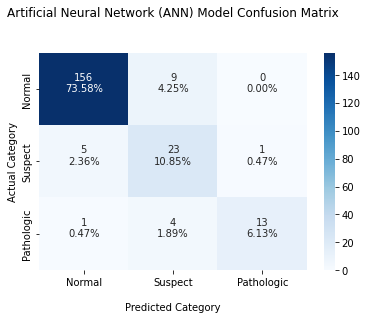

              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       165
         2.0       0.64      0.79      0.71        29
         3.0       0.93      0.72      0.81        18

    accuracy                           0.91       212
   macro avg       0.84      0.82      0.82       212
weighted avg       0.92      0.91      0.91       212



In [ ]:
print('Batch size: ', batch_size, ' Epoch size: ', epoch_size)
print('Model Accuracy: ', max_accuracy)
cof_mat(cf_matrix, 'Artificial Neural Network (ANN)')
print(clf_report)

### Random Forest

#### Model Training

In [ ]:
## To print the best parameter values
def print_cv(cv, X, y, model_name):
    """ Prints best score, best parameter values, and in and out of sample confusion matrices for a cv
    result """
    print('Results for {}:'.format(model_name))
    print('The best out-of-sample performance is {}'.format(cv.best_score_))
    print('Best parameter values: ', cv.best_params_)

    pred = cv.best_estimator_.predict(X)
    print('In-sample confusion matrix of best estimator:\n{}'.format(sklearn.metrics.confusion_matrix(y, pred)))

    cross_val_pred = sklearn.model_selection.cross_val_predict(cv.best_estimator_, X, y, cv=5, n_jobs=-1)
    print('Out-of-sample confusion matrix of best estimator:\n{}'.format(
        sklearn.metrics.confusion_matrix(y, cross_val_pred)))

    return

In [ ]:
seed = 42
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=10,
    bootstrap=True, oob_score=False, n_jobs=-1, random_state=seed, class_weight='balanced')

# values for cross-validation
# Number of trees in random forest
tree_numbers = [20, 50, 100, 200]
# Maximum number of levels in tree
tree_depths = [1, 2, 3, 4, 5, 6, 7, 8]
# Number of features to consider at every split
max_feature_vals = [3, 5, 8, 10, 15]

random_forest_grid = {"n_estimators": tree_numbers,
    "max_depth": tree_depths,
    "max_features": max_feature_vals}

random_forest_cv = sklearn.model_selection.GridSearchCV(random_forest, random_forest_grid,
    scoring='balanced_accuracy', n_jobs=-1, refit=True, verbose=True, return_train_score=True, cv=5)

random_forest_cv.fit(X_train_featured, y_train)
print_cv(random_forest_cv, X_train_featured, y_train, 'Random forest')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Results for Random forest:
The best out-of-sample performance is 0.8949851137427217
Best parameter values:  {'max_depth': 5, 'max_features': 5, 'n_estimators': 200}
In-sample confusion matrix of best estimator:
[[1364  114    3]
 [  21  240    2]
 [   2    4  150]]
Out-of-sample confusion matrix of best estimator:
[[1356  117    8]
 [  34  226    3]
 [   6    8  142]]


In [ ]:
seed = 42
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=5,
    bootstrap=True, oob_score=False, n_jobs=-1, random_state=seed, class_weight='balanced')

random_forest.fit(X_train_featured, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
y_pred = random_forest.predict(X_test_featured)

#### Confusion Matrix Report

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)

Model Accuracy:  0.9009433962264151


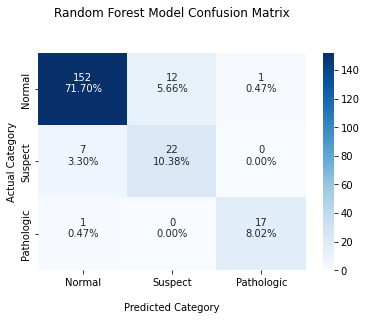

              precision    recall  f1-score   support

         1.0       0.95      0.92      0.94       165
         2.0       0.65      0.76      0.70        29
         3.0       0.94      0.94      0.94        18

    accuracy                           0.90       212
   macro avg       0.85      0.87      0.86       212
weighted avg       0.91      0.90      0.90       212



In [ ]:
print('Model Accuracy: ', accuracy_score(y_test, y_pred))
cof_mat(cf_matrix, 'Random Forest')
print(clf_report)